## TTITrace分析脚本-TDD
---
**环境**：
- Python 3.5+
- pandas 0.18.1+
- matlibplot 2.0.0+
- numpy 1.11.3

**功能**

**历史**
- 0.01: 2017/07/31
- 0.02: 2018/03/30, 增加MU-MIMO信息

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

# TTITRACE_PATH = r"D:\userdata\anliu\Desktop\New folder\pstool"
TTITRACE_PATH = r"D:\userdata\anliu\Desktop\log\IRAN\pstools\TtiTracer"
# FILENAME_DL = "tti_online_20180202142755_2267110B_dl_0001.csv"
# FILENAME_UL = "tti_online_20180202142755_226A110D_ul_0001.csv"
FILENAME_UL = "ttiTraceHb.csv"

# 读取csv文件，返回有效数据起始行数
def csv_prepare(file, comment="Time"):
    nrow = 0
    with open(file,"r") as f:
        for line in f:
            nrow = nrow + 1
            if line.startswith(comment): 
                return nrow-1

# 从CSV文件中读取数据并存储为dataframe
def load_tti_data(ttitrace_path=TTITRACE_PATH, ttitrace_name=FILENAME_DL):
    file = os.path.join(ttitrace_path, ttitrace_name)
    csv_data = pd.read_csv(file, low_memory=True, skiprows=csv_prepare(file), 
                           na_values=['-'], error_bad_lines=False, warn_bad_lines=False)
    return csv_data

### Analyze DL ttitrace

In [2]:
# 整理dataframe文件，删除不必要的数据，规整数据格式
dl_columns = ['Time', 'ETtiTraceDlParCell_sfn', 'ETtiTraceDlParCell_esfn', 'ETtiTraceDlParCell_cellId', 
              'ETtiTraceDlParCell_numUesFd','ETtiTraceDlParCell_totalPrbAvail', 'ETtiTraceDlParCell_dlsPdschUtilRatio',
              'ETtiTraceDlParUe_crnti', 'ETtiTraceDlParUe_numDrb', 'ETtiTraceDlParUe_dataInDrb1', 
              'ETtiTraceDlParUe_dataInDrb2', 'ETtiTraceDlParUe_dataInDrb3', 'ETtiTraceDlParUe_numberOfPrbAlloc',
              'ETtiTraceDlParUe_tbsCw1', 'ETtiTraceDlParUe_tbsCw2', 'ETtiTraceDlParUe_wbCqiCw0', 'ETtiTraceDlParUe_wbCqiCw1',
              'ETtiTraceDlParUe_ModulationCw1', 'ETtiTraceDlParUe_ModulationCw2', 'ETtiTraceDlParUe_mcsIndexCw1',
              'ETtiTraceDlParUe_mcsIndexCw2', 'ETtiTraceDlParUe_spatialMode', 'ETtiTraceDlParUe_rrmPdschAvgUeTput', 
              'EHarqParDl_ackNackDtxCw1', 'EHarqParDl_ackNackDtxCw2', 'ETtiTraceDlParUe_CaUeType', 'ETtiTraceDlParUe_sCellState0',
              'ETtiTraceDlParUe_muStatus']
ttitrace_dl = load_tti_data(TTITRACE_PATH, FILENAME_DL)
ttitrace_dl = ttitrace_dl.loc[:, dl_columns]
ttitrace_dl.dropna(axis=0, subset=['ETtiTraceDlParUe_crnti','ETtiTraceDlParCell_cellId'], inplace=True)
print(ttitrace_dl.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49066 entries, 0 to 61200
Data columns (total 28 columns):
Time                                    49066 non-null object
ETtiTraceDlParCell_sfn                  49066 non-null int64
ETtiTraceDlParCell_esfn                 49066 non-null int64
ETtiTraceDlParCell_cellId               49066 non-null int64
ETtiTraceDlParCell_numUesFd             49066 non-null int64
ETtiTraceDlParCell_totalPrbAvail        49066 non-null int64
ETtiTraceDlParCell_dlsPdschUtilRatio    49066 non-null int64
ETtiTraceDlParUe_crnti                  49066 non-null float64
ETtiTraceDlParUe_numDrb                 48951 non-null float64
ETtiTraceDlParUe_dataInDrb1             48951 non-null float64
ETtiTraceDlParUe_dataInDrb2             48951 non-null float64
ETtiTraceDlParUe_dataInDrb3             48951 non-null float64
ETtiTraceDlParUe_numberOfPrbAlloc       49066 non-null float64
ETtiTraceDlParUe_tbsCw1                 49066 non-null float64
ETtiTraceDlParUe_tbsCw

In [3]:
# 抽取Cell ID，PRB数目
# ttitrace中每个tti对应多个UE的调度，在统计某些参数时候需要对统一时间戳的数值求和，比如单tti调度的prb数目prb_used
cell_id = ttitrace_dl['ETtiTraceDlParCell_cellId'][0]
prb_available = ttitrace_dl.groupby('Time')['ETtiTraceDlParCell_totalPrbAvail'].mean()
prb_available_mean = prb_available.mean()
prb_used = ttitrace_dl.groupby('Time')['ETtiTraceDlParUe_numberOfPrbAlloc'].sum()
prb_used_mean = prb_used.mean()
print('cell id:', int(cell_id))
print('available prb number: {:.1f}'.format(prb_available_mean))
print('prb allocated: {:.1f}'.format(prb_used_mean))

# 统计 cqi
wbcqi_cw1 = ttitrace_dl["ETtiTraceDlParUe_wbCqiCw0"].mean()
wbcqi_cw2 = ttitrace_dl["ETtiTraceDlParUe_wbCqiCw1"].mean()
print('wbcqi on cw1: {:.1f}'.format(wbcqi_cw1))
print('wbcqi on cw2: {:.1f}'.format(wbcqi_cw2))

# 统计fd（dl subframe UE per tti）
dl_fd_num = ttitrace_dl['ETtiTraceDlParCell_numUesFd'].mean()
print('dl mean FD number: {:.1f}'.format(dl_fd_num))

# 分别对单tti和总测试时间段统计dl mcs
dl_mcs_index_cw1 = ttitrace_dl.groupby('Time')['ETtiTraceDlParUe_mcsIndexCw1'].mean()
dl_mcs_index_cw2 = ttitrace_dl.groupby('Time')['ETtiTraceDlParUe_mcsIndexCw2'].mean()
dl_mcs_index_cw1_mean = dl_mcs_index_cw1.mean()
dl_mcs_index_cw2_mean = dl_mcs_index_cw2.mean()
print('dl mean mcs for cw1: {:.1f}'.format(dl_mcs_index_cw1_mean))
print('dl mean mcs for cw2: {:.1f}'.format(dl_mcs_index_cw2_mean))

# 分别对单tti和总测试时间段统计dl tb size
dl_tbs_cw1 = ttitrace_dl.groupby('Time')['ETtiTraceDlParUe_tbsCw1'].sum()
dl_tbs_cw2 = ttitrace_dl.groupby('Time')['ETtiTraceDlParUe_tbsCw2'].sum()
dl_tbs_cw1_mean = dl_tbs_cw1.mean()
dl_tbs_cw2_mean = dl_tbs_cw2.mean()
print('dl mean tbs for cw1: {:.1f}'.format(dl_tbs_cw1_mean))
print('dl mean tbs for cw2: {:.1f}'.format(dl_tbs_cw2_mean))

# 统计dl ack ratio，dl harq状态包括ack，ack，dtx
dl_ack_cw1_group = ttitrace_dl.groupby('EHarqParDl_ackNackDtxCw1')
dl_ack_cw2_group = ttitrace_dl.groupby('EHarqParDl_ackNackDtxCw2')
dl_ack_cw1 = dl_ack_cw1_group.size()['ACK']/dl_ack_cw1_group.size().sum()
dl_ack_cw2 = dl_ack_cw2_group.size()['ACK']/dl_ack_cw2_group.size().sum()
print('dl harq ack ratio for cw1: {:.1f}%'.format(dl_ack_cw1*100))
print('dl harq ack ratio for cw2: {:.1f}%'.format(dl_ack_cw2*100))

# 统计DRB数目
dl_drb_count = ttitrace_dl['ETtiTraceDlParUe_numDrb'].mean()
print('drb number is: {:.1f}'.format(dl_drb_count))

cell id: 10
available prb number: 100.0
prb allocated: 57.9
wbcqi on cw1: 14.2
wbcqi on cw2: 14.2
dl mean FD number: 2.5
dl mean mcs for cw1: 16.5
dl mean mcs for cw2: 21.5
dl mean tbs for cw1: 3365.3
dl mean tbs for cw2: 3399.3
dl harq ack ratio for cw1: 90.2%
dl harq ack ratio for cw2: 88.6%
drb number is: 1.0


FD number VS Subframe number:


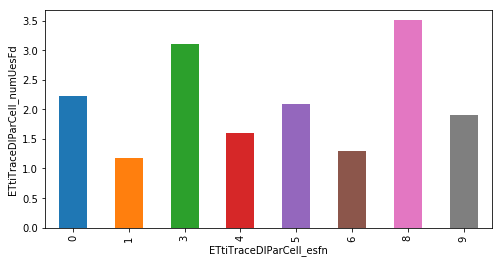

CW1/CW2 MCS Index Distribution:


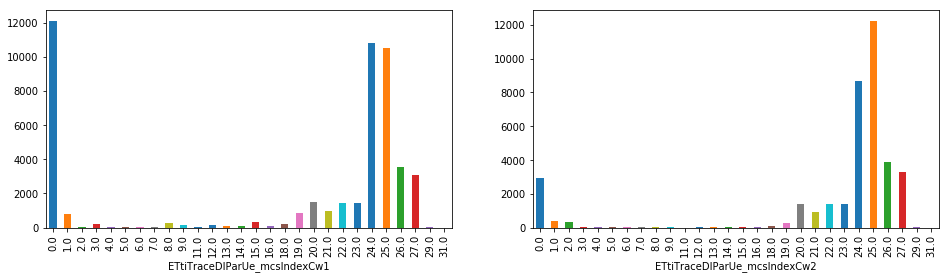

CW1/CW2 ACK/NACK/DTX Distribution:


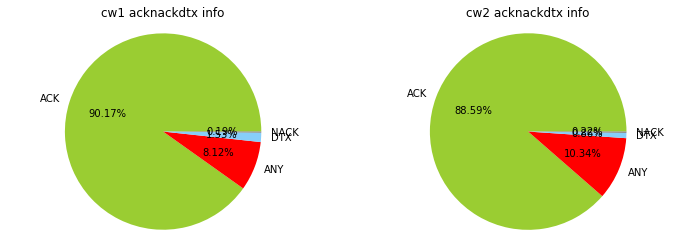

DRB Number Distribution:


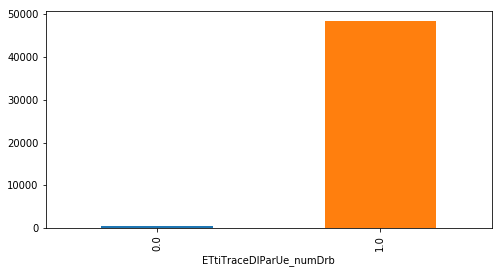

DRB Buffer VS Time:


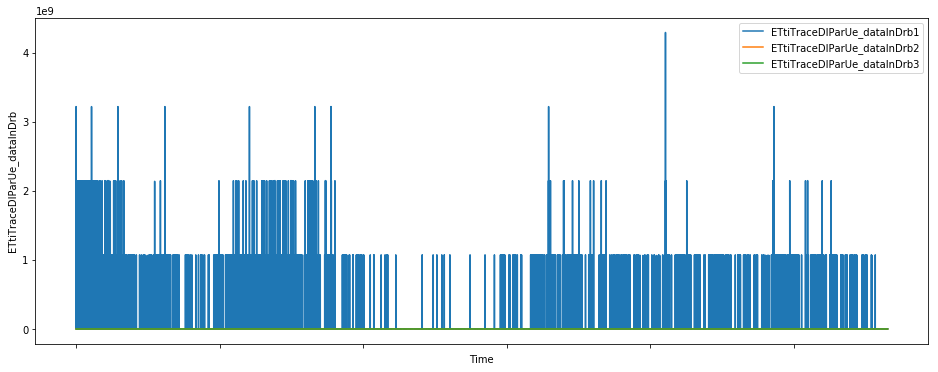

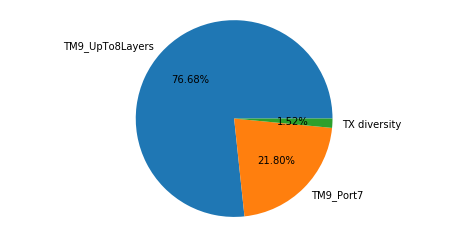

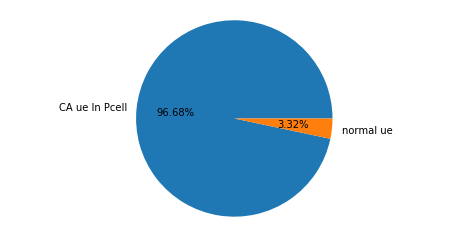

In [4]:
# 可视化

# dl subframe UE per tti数目的分布
print('FD number VS Subframe number:')
fig = plt.figure(figsize=(8,4))
dl_esfn_vs_fd = ttitrace_dl.groupby('ETtiTraceDlParCell_esfn')['ETtiTraceDlParCell_numUesFd'].mean()
ax = dl_esfn_vs_fd.plot(kind='bar')
ax.set_xlabel('ETtiTraceDlParCell_esfn')
ax.set_ylabel('ETtiTraceDlParCell_numUesFd')
plt.show()

# cw1和cw2 mcs的分布
print('CW1/CW2 MCS Index Distribution:')
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121)
# ax1 = ttitrace_dl['ETtiTraceDlParUe_mcsIndexCw1'].value_counts().plot(kind='bar')
ax1 = ttitrace_dl.groupby('ETtiTraceDlParUe_mcsIndexCw1').size().plot(kind='bar')
ax2 = fig.add_subplot(122)
# ax2 = ttitrace_dl['ETtiTraceDlParUe_mcsIndexCw2'].value_counts().plot(kind='bar')
ax2 = ttitrace_dl.groupby('ETtiTraceDlParUe_mcsIndexCw2').size().plot(kind='bar')
plt.show()

# cw1和cw2 ACK/NACK/DTX的百分比
print('CW1/CW2 ACK/NACK/DTX Distribution:')
fig = plt.figure(figsize=(12,4))
colors = ['yellowgreen', 'red', 'lightskyblue', 'grey']
ax1 = fig.add_subplot(121)
ax1 = ttitrace_dl['EHarqParDl_ackNackDtxCw1'].value_counts().plot(kind='pie', autopct='%1.2f%%', colors=colors)
ax1.axis('equal')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('cw1 acknackdtx info')
ax2 = fig.add_subplot(122)
ax2 = ttitrace_dl['EHarqParDl_ackNackDtxCw2'].value_counts().plot(kind='pie', autopct='%1.2f%%', colors=colors)
ax2.axis('equal')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('cw2 acknackdtx info')
plt.show()

# DRB数量分布
print('DRB Number Distribution:')
fig = plt.figure(figsize=(8,4))
ax = ttitrace_dl.groupby('ETtiTraceDlParUe_numDrb').size().plot(kind='bar')
plt.show()

# DRB Buffer中数据分布
print('DRB Buffer VS Time:')

dl_drb_vs_time = ttitrace_dl.groupby('Time')[['ETtiTraceDlParUe_dataInDrb1','ETtiTraceDlParUe_dataInDrb2',
                                              'ETtiTraceDlParUe_dataInDrb3']].sum()
ax = dl_drb_vs_time.plot(kind='line', figsize=(16,6))
ax.set_xlabel('Time')
ax.set_ylabel('ETtiTraceDlParUe_dataInDrb')
plt.show()

# MIMO模式分布
fig = plt.figure(figsize=(8,4))
ax = ttitrace_dl['ETtiTraceDlParUe_spatialMode'].value_counts().plot(kind='pie', autopct='%1.2f%%')
ax.axis('equal')
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

# CA UE分布
fig = plt.figure(figsize=(8,4))
ax = ttitrace_dl['ETtiTraceDlParUe_CaUeType'].value_counts().plot(kind='pie', autopct='%1.2f%%')
ax.axis('equal')
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

# MU-MIMO 分布
# fig = plt.figure(figsize=(8,4))
# ax = ttitrace_dl['ETtiTraceDlParUe_muStatus'].value_counts().plot(kind='pie', autopct='%1.2f%%')
# ax.axis('equal')
# ax.set_xlabel('')
# ax.set_ylabel('')
# plt.show()

### Analyze UL ttitrace

In [14]:
print('Start to analyze UL ttitrace...')

# 读取数据并整理
ttitrace_ul = load_tti_data(TTITRACE_PATH, FILENAME_UL)
ttitrace_ul = ttitrace_ul.iloc[:,:-1]
ttitrace_ul.dropna(subset=["ETtiTraceUlParUe_crnti", "ETtiTraceUlParCell_esfn"], axis=0, inplace=True)
ttitrace_ul.reset_index(inplace=True)

# 打印dataframe基本信息
ttitrace_ul.info()

Start to analyze UL ttitrace...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15290 entries, 0 to 15289
Columns: 274 entries, index to EHarqParUl_rrmOlqcUpdateModeCw1
dtypes: float64(201), int64(22), object(51)
memory usage: 32.0+ MB


In [15]:
# 抽取Cell ID，PRB数目
# ttitrace中每个tti对应多个UE的调度，在统计某些参数时候需要对统一时间戳的数值求和，比如单tti调度的prb数目prb_used
cell_id = ttitrace_ul['ETtiTraceUlParCell_cellId'][0]
prb_available = ttitrace_ul.groupby('Time')['ETtiTraceUlParCell_totalPrbAvail'].mean()
prb_available_mean = prb_available.mean()
prb_used = ttitrace_ul.groupby('Time')['ETtiTraceUlParUe_numberofPrbAlloc'].sum()
prb_used_mean = prb_used.mean()
print('cell id:', int(cell_id))
print('available prb number: {:.1f}'.format(prb_available_mean))
print('prb allocated: {:.1f}'.format(prb_used_mean))

# 统计fd（ul subframe UE per tti）
ul_fd_num = ttitrace_ul['ETtiTraceUlParCell_numUesFd'].mean()
print('ul mean FD number: {:.2f}'.format(ul_fd_num))

# 统计PUCCH/PUSCH rssi/sinr
ul_pusch_rssi_mean = ttitrace_ul['ETtiTraceUlParUe_rssiPuschAvg'].mean()
ul_pucch_rssi_mean = ttitrace_ul['ETtiTraceUlParUe_rssiPucchAvg'].mean()
ul_pusch_sinr_mean = ttitrace_ul['ETtiTraceUlParUe_sinrPuschAvg'].mean()
ul_pucch_sinr_mean = ttitrace_ul['ETtiTraceUlParUe_sinrPucchAvg'].mean()
print('ul pusch rssi mean: {:.2f}dBm'.format(ul_pusch_rssi_mean))
print('ul pucch rssi mean: {:.2f}dBm'.format(ul_pucch_rssi_mean))
print('ul pusch sinr mean: {:.2f}dB'.format(ul_pusch_sinr_mean))
print('ul pucch sinr mean: {:.2f}dB'.format(ul_pucch_sinr_mean))

# 分别对单tti和总测试时间段统计ul mcs
ul_mcs_index_cw1 = ttitrace_ul['ETtiTraceUlParUe_mcsIndexCw1']
ul_mcs_index_cw1_mean = ul_mcs_index_cw1.mean()
print('ul mean mcs for cw1: {:.2f}'.format(ul_mcs_index_cw1_mean))

# 分别对单tti和总测试时间段统计ul tb size
ul_tbs_cw1 = ttitrace_ul.groupby('Time')['ETtiTraceUlParUe_tbsCw1'].sum()
print('ul mean tbs for cw1: {:.2f}'.format(ul_tbs_cw1.mean()))

# 统计ul ack ratio，dl harq状态包括ack，ack，dtx
ul_ack_cw1_group = ttitrace_ul.groupby('EHarqParUl_ackNackDtxCw1')
ul_ack_cw1 = ul_ack_cw1_group.size()['ACK']/ul_ack_cw1_group.size().sum()
print('ul harq ACK ratio for cw1: {:.2f}%'.format(ul_ack_cw1*100))

# 统计DRB数目
ul_drb_count = ttitrace_ul['ETtiTraceUlParUe_numDrb'].mean()
print('drb number is: {:.1f}'.format(ul_drb_count))

cell id: 31
available prb number: 90.5
prb allocated: 6.3
ul mean FD number: 1.26
ul pusch rssi mean: -97.98dBm
ul pucch rssi mean: -102.39dBm
ul pusch sinr mean: 18.05dB
ul pucch sinr mean: 11.44dB
ul mean mcs for cw1: 21.91
ul mean tbs for cw1: 371.12
ul harq ACK ratio for cw1: 95.79%
drb number is: 0.9


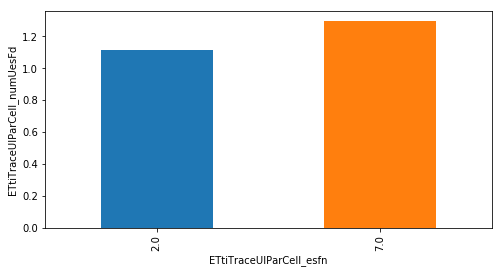

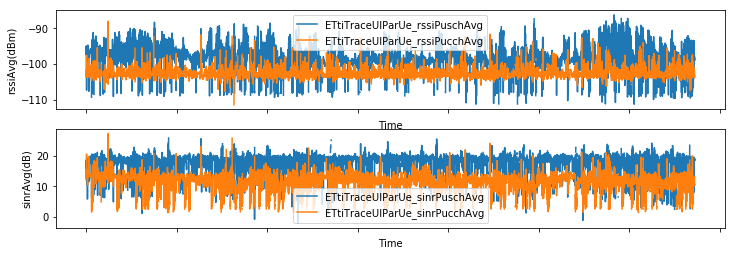

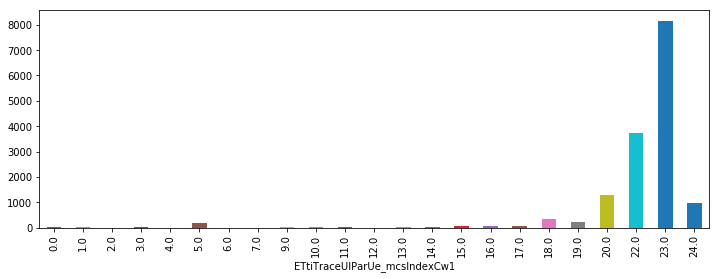

DRB Number Distribution:


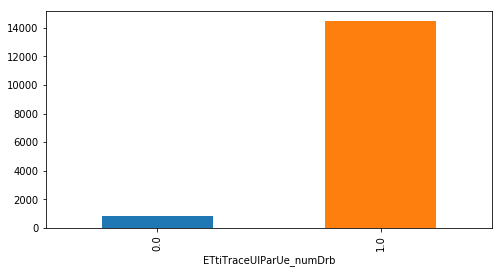

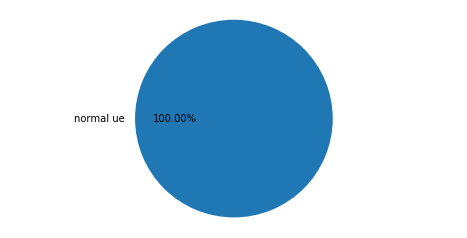

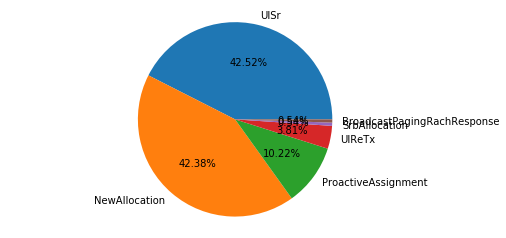

In [16]:
# 可视化

# ul subframe UE per tti数目的分布
fig = plt.figure(figsize=(8,4))
ul_esfn_vs_fd = ttitrace_ul.groupby('ETtiTraceUlParCell_esfn')['ETtiTraceUlParCell_numUesFd'].mean()
ax = ul_esfn_vs_fd.plot(kind='bar')
ax.set_xlabel('ETtiTraceUlParCell_esfn')
ax.set_ylabel('ETtiTraceUlParCell_numUesFd')
plt.show()

# ul rssi/sinr分布
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(211)
ul_rssi_vs_time = ttitrace_ul.groupby('Time')[['ETtiTraceUlParUe_rssiPuschAvg','ETtiTraceUlParUe_rssiPucchAvg']].mean()
ul_rssi_vs_time.plot(ax=ax1)
ax1.set_xlabel('Time')
ax1.set_ylabel('rssiAvg(dBm)')

ax2 = fig.add_subplot(212)
ul_sinr_vs_time = ttitrace_ul.groupby('Time')[['ETtiTraceUlParUe_sinrPuschAvg','ETtiTraceUlParUe_sinrPucchAvg']].mean()
ul_sinr_vs_time.plot(ax=ax2)
ax2.set_xlabel('Time')
ax2.set_ylabel('sinrAvg(dB)')
plt.show()

# cw1 mcs的分布
fig = plt.figure(figsize=(12,4))
ax = ttitrace_ul.groupby('ETtiTraceUlParUe_mcsIndexCw1').size().plot(kind='bar')
plt.show()

# DRB数量分布
print('DRB Number Distribution:')
fig = plt.figure(figsize=(8,4))
ax = ttitrace_ul.groupby('ETtiTraceUlParUe_numDrb').size().plot(kind='bar')
plt.show()

# CA UE分布
fig = plt.figure(figsize=(8,4))
ax = ttitrace_ul['ETtiTraceUlParUe_CaUeType'].value_counts().plot(kind='pie', autopct='%1.2f%%')
ax.axis('equal')
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

# Schedule Tag
fig = plt.figure(figsize=(8,4))
ax = ttitrace_ul['ETtiTraceUlParUe_rrmScheduleTag'].value_counts().plot(kind='pie', autopct='%1.2f%%')
ax.axis('equal')
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()